In [189]:
from __future__ import division

import numpy as np
import os
from glob import glob
import scipy

from PIL import Image
from copy import deepcopy

from sklearn import linear_model, datasets, neighbors
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn import svm

%matplotlib inline
from scipy.misc import imread, imresize
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
sns.set_context('notebook', font_scale=1.5)
from mpl_toolkits.axes_grid.anchored_artists import AnchoredText


# import torch
# import torchvision.models as models
# import torch.nn as nn
# import torchvision.transforms as transforms
# import torch.nn.functional as F
# from torch.autograd import Variable
# import sys
# sys.path.insert(0, '/home/rslee/sketchfeat/sketches')


# import embedding as emb
# reload(emb)
# from embedding import *


import pandas as pd
import pickle

VGG_SIZE_X = 224
VGG_SIZE_Y = 224
VGG_SIZE_Z = 3




Hi Rachel,

Awesome! Merry Xmas. :) Hope you're enjoying your time on the west coast. 

Let's make some plots of these, right? In particular, it'd be great to see:
* For each subject, the mean evidence for the target/competitor/control1/control2 over time. This is collapsing across which object was actually drawn on each trial. Control1 and control2 could be the other two objects, sorted alphabetically. This generates as many plots as there are subjects.  
* For each target/competitor pair, the mean evidence over time. This is collapsing across subjects to evaluate the variability across items. So, for example, a few subjects were trained on bed/bench. On bed trials, how does evidence vary over time in absolute terms, and relative to bench? And vice versa. This generates 12 plots, two for each pair.  
* Pooling all subjects and objects, the mean evidence for the target/competitor/control1/control2. So this amounts to the averaged version of the first plot.  
Looking forward to seeing how these come out! 

Best,
Judy

In [51]:
# partial = pd.read_csv('/home/rslee/sketchfeat/0110171_partial.csv')
partial = pd.read_csv('/Users/sasha/Desktop/partial_sketch_full.csv')
partial['curr_winner'] = partial[['bed', 'bench', 'chair', 'table']].idxmax(axis = 1)
partial['tc_pair'] = partial[['target', 'competitor']].apply(
                                    lambda x: '{:s}/{:s}'.format(x[0], x[1]), axis = 1)


In [257]:
# metadata from the csv 
subject_names = np.unique(partial['wID'])
num_psketch = len(np.unique(partial['numSketch']))
trials = np.unique(partial['trial'])
categories = ['bed', 'bench', 'chair', 'table']
tc_pairs = np.unique(partial['tc_pair'])
print ('Number of subjects: {:d}'.format(len(subject_names)))
print ('Number of partial skecthes: {:d}'.format(num_psketch))
print ('Number of trials per subject: {:d}'.format(len(trials)))
print ('Number of target/competitor pairs: {:d}'.format(len(tc_pairs)))

Number of subjects: 35
Number of partial skecthes: 23
Number of trials per subject: 40
Number of target/competitor pairs: 12


In [242]:
def plot_average_response(df):

    sns.tsplot(data = df, time = 'numSketch', unit = 'trial', value = 'bed', color = 'b')
    sns.tsplot(data = df, time = 'numSketch', unit = 'trial', value = 'bench', color = 'r')
    sns.tsplot(data = df, time = 'numSketch', unit = 'trial', value = 'chair', color = 'g')
    sns.tsplot(data = df, time = 'numSketch', unit = 'trial', value = 'table', color = 'y')

    plt.legend(['bed', 'bench', 'chair', 'table'], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

    plt.ylabel('Probability Estaimtes \n (L2 normalized Log Reg)')
    
    
    at_corr = AnchoredText('{:.2f} % correct \n for final sketches'.format(get_percent_correct(df)),
                  prop=dict(size=14), frameon=True,
                  loc=1,
                  )

    at_target = AnchoredText('Targets: {:s} \nCompetitors: {:s} \nControls: {:s}'
                             .format(str(np.unique(df['target'])), str(np.unique(df['competitor'])), 
                                    str([x for x in categories if x not in np.unique(mini[['target', 'competitor']])])),
                  prop=dict(size=14), frameon=True,
                  loc=2,
                  )


    axes = plt.gca()
    axes.set_ylim([0,1])
    axes.add_artist(at_corr)
    axes.add_artist(at_target)

    
def get_final_sketch(df):
    return df[df['numSketch'] == num_psketch -1]


def get_num_correct(df, disp = 0): 
    num_correct = sum(get_final_sketch(df).target == get_final_sketch(df).curr_winner);
    if disp == 1: 
        print(pd.concat([get_final_sketch(df).target, get_final_sketch(df).curr_winner], axis = 1));
    return num_correct


def get_percent_correct(df, disp = 0):
    return round((get_num_correct(df, disp) / len(get_final_sketch(df))) * 100, 2)

# Mean Evidence for target/competitor/control over time per subject

This is collapsing across which object was actually drawn on each trial. Control1 and control2 could be the other two objects, sorted alphabetically. This generates as many plots as there are subjects. 



/Users/sasha/anaconda/envs/biomath/lib/python3.5/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


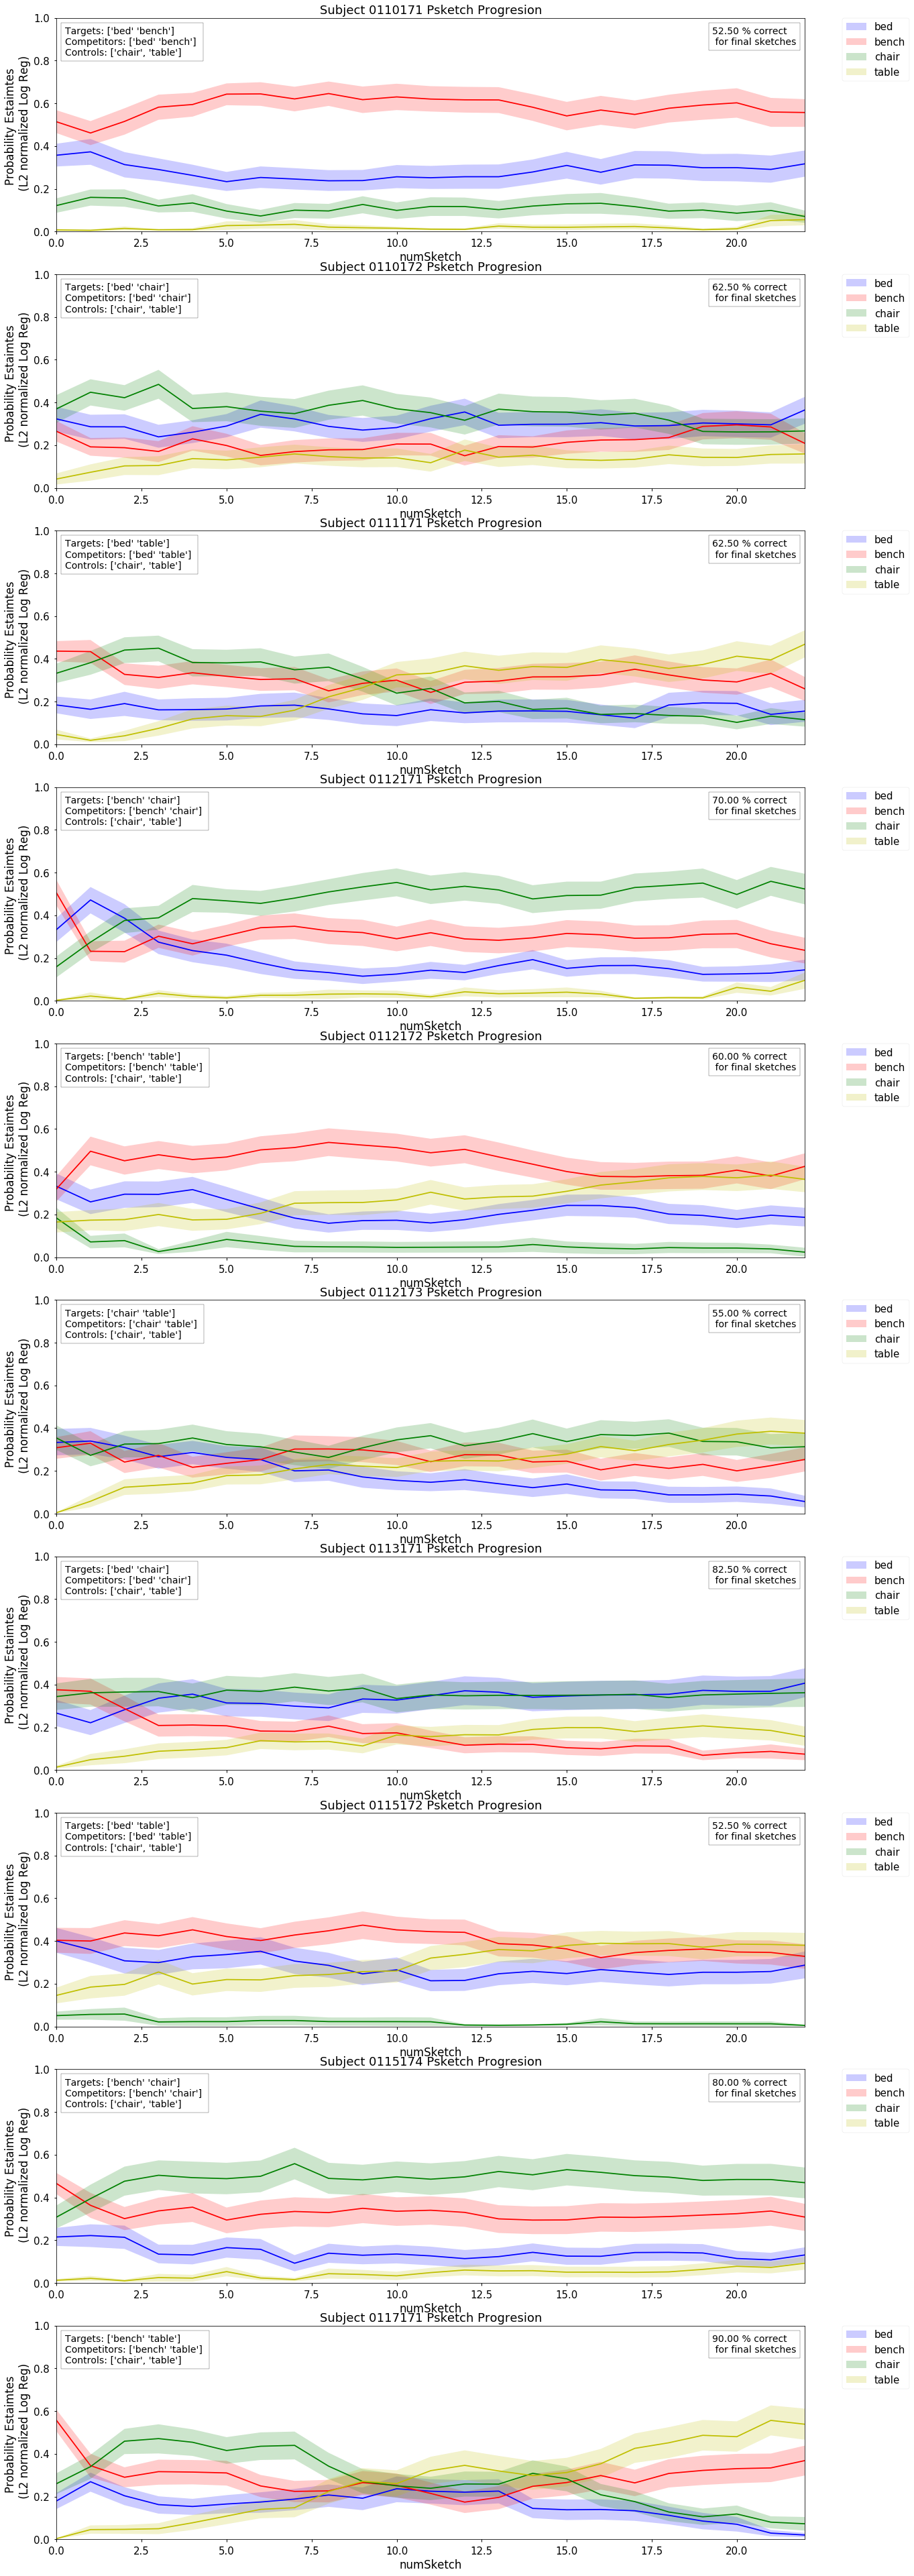

In [246]:
figure = plt.figure(figsize = (20, 7 * len(subject_names)))

for s_i, s in enumerate(subject_names[0:10]):
    plt.subplot(len(subject_names), 1, s_i + 1)
    partial_i = partial[partial['wID'] == s]
    plt.title('Subject {:s} Psketch Progresion'.format(s.split('_')[0]))
    plot_average_response(partial_i)

    

/Users/sasha/anaconda/envs/biomath/lib/python3.5/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


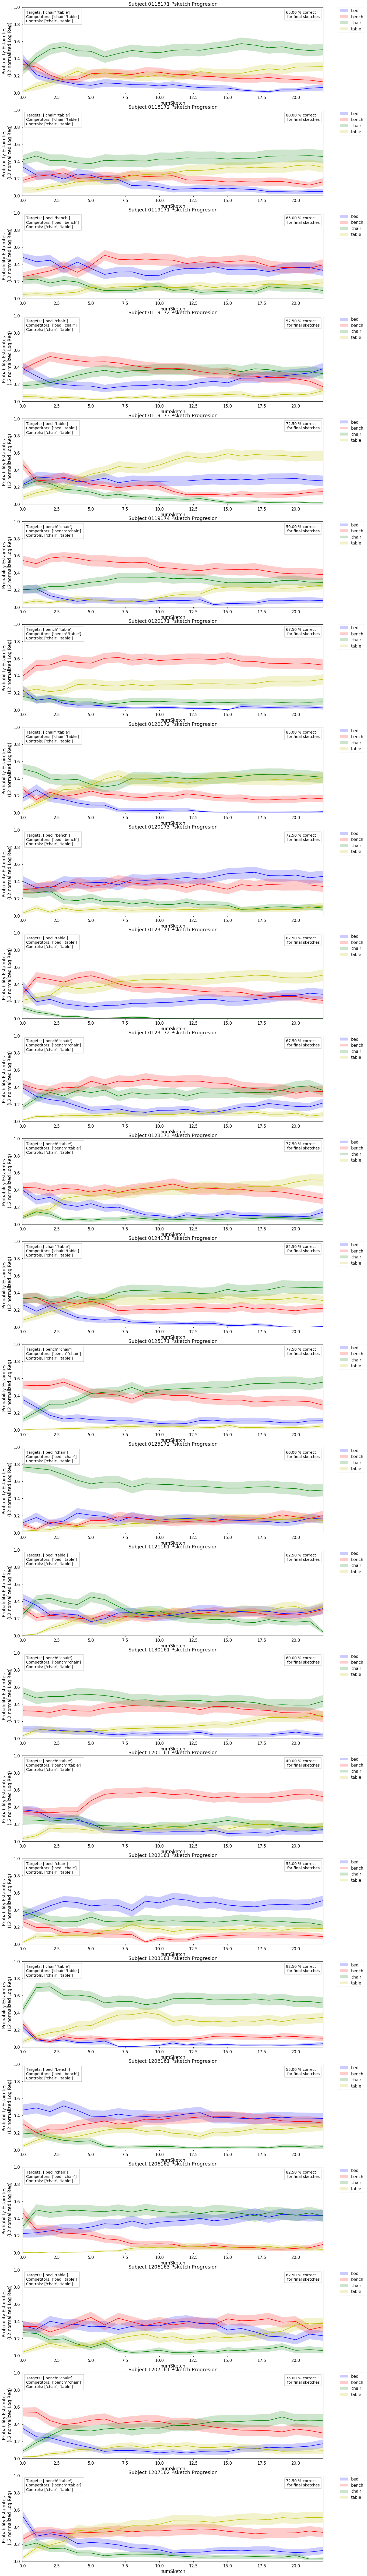

In [247]:
figure = plt.figure(figsize = (20, 7 * len(subject_names)))

for s_i, s in enumerate(subject_names[10:]):
    plt.subplot(len(subject_names), 1, s_i + 1)
    partial_i = partial[partial['wID'] == s]
    plt.title('Subject {:s} Psketch Progresion'.format(s.split('_')[0]))
    plot_average_response(partial_i)

# Mean Evidence for target/competitor/control over time per target/competitor pair 

For each target/competitor pair, the mean evidence over time. This is collapsing across subjects to evaluate the variability across items. So, for example, a few subjects were trained on bed/bench. On bed trials, how does evidence vary over time in absolute terms, and relative to bench? And vice versa. This generates 12 plots, two for each pair.


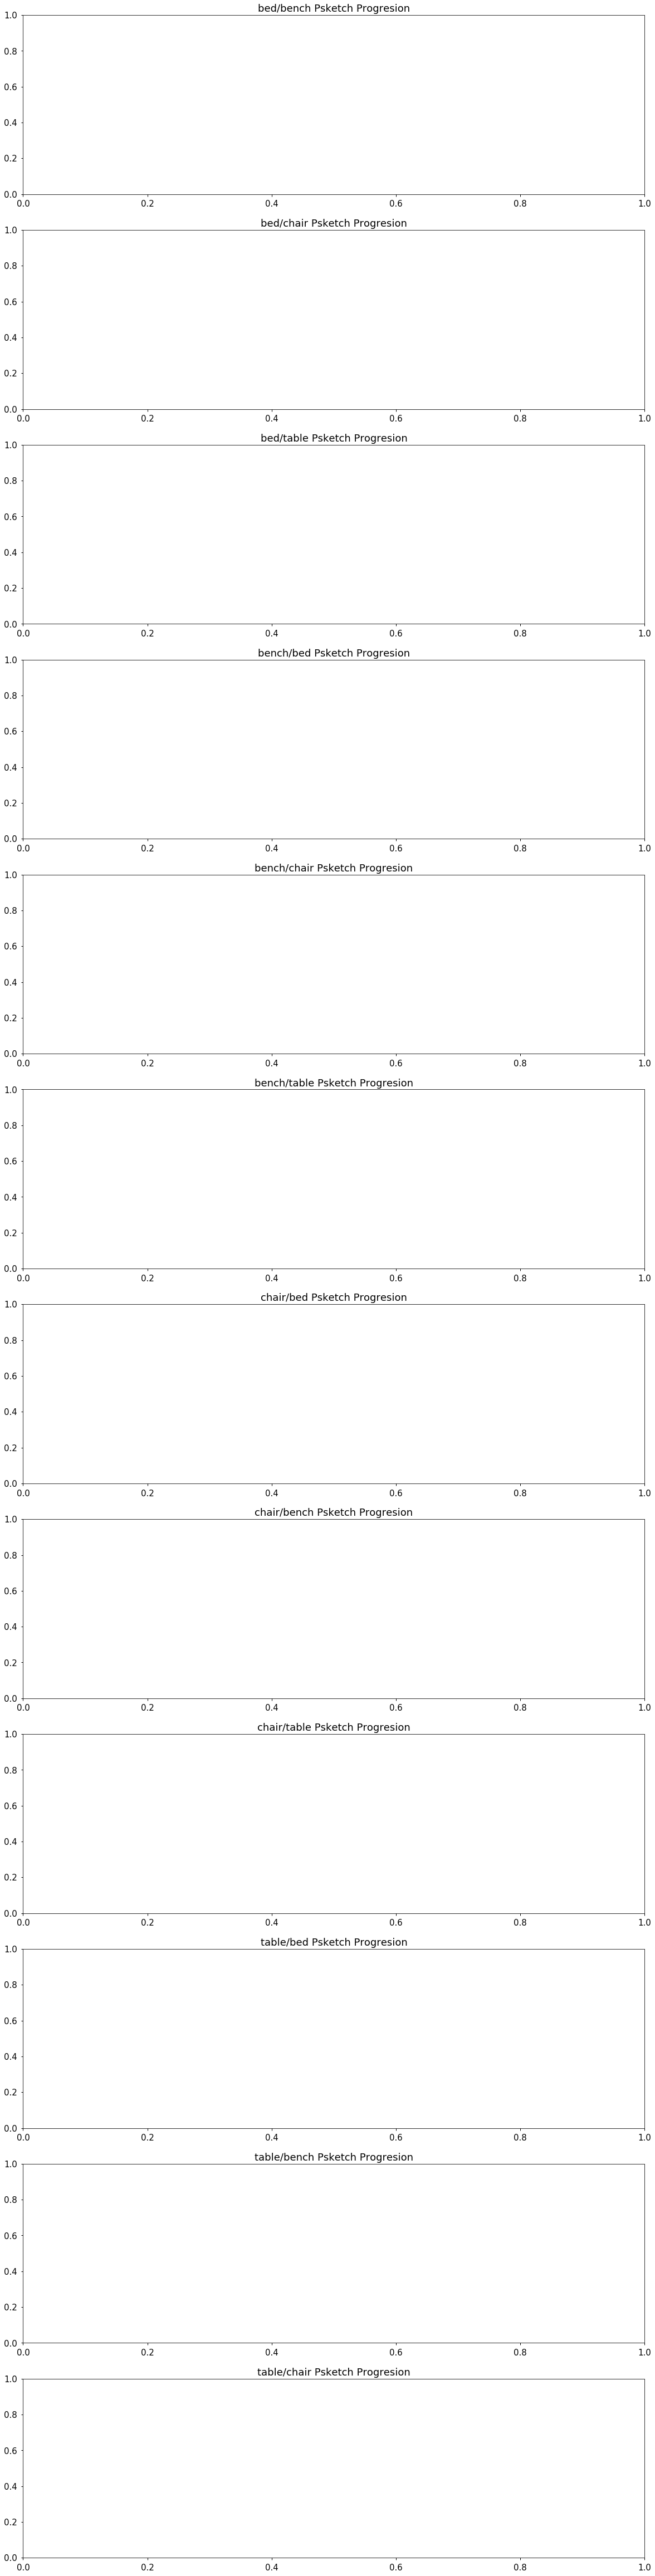

In [261]:
figure = plt.figure(figsize = (20, 7 * len(tc_pairs)))

for tc_i, tc in enumerate(tc_pairs):
    plt.subplot(len(tc_pairs), 1, tc_i + 1)
    partial_i = partial[partial['tc_pair'] == tc]
    plt.title('{:s} Psketch Progresion'.format(tc))
#     plot_average_response(partial_i)



/Users/sasha/anaconda/envs/biomath/lib/python3.5/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


ValueError: Index contains duplicate entries, cannot reshape

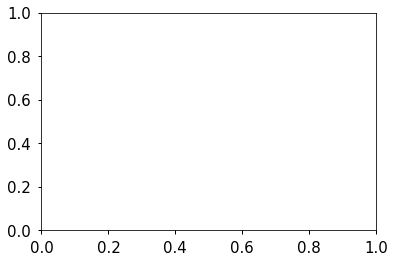

In [263]:
plot_average_response(partial_i)